# Learning Maps, part 3

Remember this graph?  

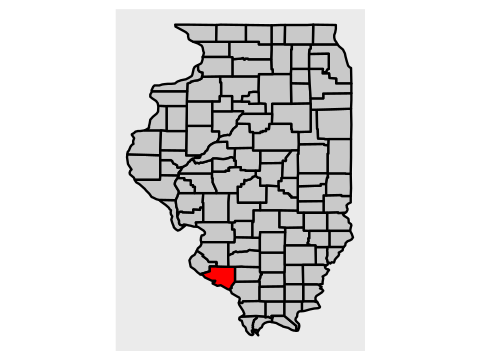

In [2]:
#---what I really ended up doing...
require(ggplot2)
require(maps)

#---resize plots
options(
    repr.plot.width=4, 
    repr.plot.height=3
)

#---get USA county-level data
dat<-map_data("county")

#---focus on just illinois
IL<-subset(dat,region=="illinois")

#---find all county names
county.names<-unique(IL$subregion)
#---pick one at random
random.county<-sample(county.names,1)

#---create identifier vector... simple logical test
county.identifier<-IL$subregion==random.county
#---add to data frame
IL<-data.frame(IL,county.identifier)

#---plot map, using identifier to distinguish color
#---ggplot!!
ggplot(
    #---Illinois county boundaries
    data=IL,
    #---aesthetics
    aes(
        #---long and lat
        x=long,
        y=lat,
        #---group county boundaries together
        group=subregion
    )    
)+

#---add geometry -- polygons!!
geom_polygon(
    #---set line color
    color="black",
    #---FILL COLOR DISTINGUISHED BY COUNTY IDENTIFIER!!!
    aes(fill=county.identifier)
)+

#---scale for fill allows custom setting of colors
scale_fill_manual(
    #---values is a named vector -- level and color.
    values=(
        c(
        "TRUE"="red",
        "FALSE"="grey79"
        )
    )
)+

#---no guide, err, legend, for fill
guides(fill="none")+

#---aspect ratio!!!
coord_fixed()+

#---get rid of axis titles!
xlab(NULL)+
ylab(NULL)+

#---get rid of numbers on the axes!!
scale_x_continuous(breaks=NULL)+
scale_y_continuous(breaks=NULL)

Time to recreate it -- prove it wasn't a fluke! -- using some more localized data.  And some fairly newsworthy data.  You may have heard about its relevance [here](https://www.chicagotribune.com/news/politics/elections/ct-chicago-viz-mayor-runoff-election-precinct-map-2019-htmlstory.html).  Chicago Tribune, I'm coming for you!

My goal:
- Get Chicago precinct boundary data
- Create a map with the data
- Maybe create a snazzy background to the map
- Create a function that highlights a precincts from a given ward
- Layer with some election data...
- Create a shiny app to put it all together

Shooting for the moon towards the end of that list.  No half way with all this!!

So for the first point, I know where to look.  The [City of Chicago Data Portal](https://data.cityofchicago.org/).  On that website, I can find a map of the precinct boundaries under the "Facilities and Geographic Boundaries".  [The map allows you to download the 'geospatial' data as KML, KMZ, Shapefile, 'Original', or GeoJSON.](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Precincts-current-/uvpq-qeeq)  I'm doing R.  I want a data frame, and I want latitude and longitude in that data frame.  I'm sure I can get one of those formats into such a data frame, but I'm not sure how.  Time to figure it out.

Preliminary googling tells me the R package [`rgdal`](https://cran.r-project.org/web/packages/rgdal/rgdal.pdf) can help get geospatial data into R.  I'm thinking 'geospatial' casts a pretty wide net, here... (and I noticed 'gdal' stands for **g**eospatial  **d**ata **a**bstraction **l**anguage)  For now I'll see what I can do with, say, KML files.  
A bit more clicking around and I sense that `rgdal` brings some serious power.  I created a super-duper basic map in Google My Maps, exported it as KML (`MapTest.KML`), and looked at what `rgdal` could do for me.  There's a function `ogrListLayers` to determine the layers in a KML file, and a function `readOGR` to get the data from the map into R.

In [3]:
require(rgdal)
ogrListLayers("MapTest.kml")

readOGR("MapTest.kml",layer="Layer1")->KML.dat

KML.dat

Loading required package: rgdal
Loading required package: sp
rgdal: version: 1.2-5, (SVN revision 648)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.3, released 2015/09/16
 Path to GDAL shared files: /usr/share/gdal/1.11
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-3 


[1] "Layer1"
attr(,"driver")
[1] "LIBKML"
attr(,"nlayers")
[1] 1

OGR data source with driver: LIBKML 
Source: "MapTest.kml", layer: "Layer1"
with 2 features
It has 11 fields


Warning message in readOGR("MapTest.kml", layer = "Layer1"):
“Z-dimension discarded”

An object of class "SpatialPolygonsDataFrame"
Slot "data":
     Name                     description timestamp begin  end altitudeMode
1 Shape_1 This is the first shape I made.      <NA>  <NA> <NA>         <NA>
2 Shape_2            Look, another shape.      <NA>  <NA> <NA>         <NA>
  tessellate extrude visibility drawOrder icon
1         -1      -1         -1        NA <NA>
2         -1      -1         -1        NA <NA>

Slot "polygons":
[[1]]
An object of class "Polygons"
Slot "Polygons":
[[1]]
An object of class "Polygon"
Slot "labpt":
[1] -87.64700  41.90029

Slot "area":
[1] 0.001157012

Slot "hole":
[1] FALSE

Slot "ringDir":
[1] 1

Slot "coords":
          [,1]     [,2]
[1,] -87.61595 41.88996
[2,] -87.66195 41.88791
[3,] -87.68255 41.90938
[4,] -87.62693 41.91244
[5,] -87.61595 41.88996



Slot "plotOrder":
[1] 1

Slot "labpt":
[1] -87.64700  41.90029

Slot "ID":
[1] "1"

Slot "area":
[1] 0.001157012


[[2]]
An object of class "Polygons"
Slot "Polygons":
[[1]]
An object of c

Whoa.  That is a ton of data.  If I want to get really deep into maps -- like, if I wanted to mess with ArcGIS data -- I'll be back to `rgdal`.  (hint: I will be back)  But, for now, I just want lat/long coordinates.  Is there something simpler, more direct?  Another Google post hints towards the package `maptools` and the command `getKMLcoordinates`.  Sounds like my speed!  Lemme try, without looking for further documentation first.

In [46]:
require(maptools)
getKMLcoordinates("MapTest.kml")->coords

coords

-87.61595,41.88996,0
-87.62693,41.91244,0
-87.68255,41.90938,0
-87.66195,41.88791,0
-87.61595,41.88996,0
-87.64650,41.96173,0
-87.70796,41.96250,0
-87.68049,41.95407,0
-87.69422,41.91908,0
-87.64650,41.96173,0


Alright!!  I've got lat/long coordinates, so I can do something with this.  But two quick observations:

- It's not in a data frame
- The test data has two polygons; I need an identifier vector for each.  Can I make that third column 1 and then 2 to distinguish the different polygons?

I first tried to loop through each of the polygons and assign them an index value... but then I struggled to merge all the polygons together into one big data frame.  But through some googling I found an approach:  convert each polygon into a data frame, then use `bind_rows` from the `dplyr` package to put it all together.  It seems `bind_rows` each has an option to distinguish each of the polygons.  Hat tip to stackoverflow user [joeklieg](https://stackoverflow.com/a/49017065).

In [47]:
#---first turn each of the polygons into its own data frame
lapply(coords,as.data.frame)->coords

#---required!
require(dplyr)

#---reassign coordinate data
coords<-
    #---put all those individual polygon data frames together
    bind_rows(coords,
         #---create an column to distinguish each polygon!
          .id="region"
         )

#---clean it up: delete blank column, add names
coords<-coords[,-4]
names(coords)<-c("region","long","lat")

#---preview!!
coords


region,long,lat
1,-87.61595,41.88996
1,-87.62693,41.91244
1,-87.68255,41.90938
1,-87.66195,41.88791
1,-87.61595,41.88996
2,-87.64650,41.96173
2,-87.70796,41.96250
2,-87.68049,41.95407
2,-87.69422,41.91908
2,-87.64650,41.96173


Yessir.  I got KML data into a nice R data frame with latitude and longitude.  I'm ready to graph... but not that data. That's sample KML data from a little map I created.  I'm not exaggerating to say that mapping it would be the most boring thing in the world, and a waste of everyone's time.

So, the next step is obvious:  go straight on to KML data for all of Chicago's precincts.  Once I have it from the city [Data Portal](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Precincts-current-/uvpq-qeeq).... 

- Load it into R using `getKMLcoordinates`
- Convert it to a tidy data frame using the above method
- Plot a map!!

Go time:

In [56]:
#---create precinct boundary R object
precinct.boundaries<-
    #----load KML data
    getKMLcoordinates(
        #---load my desired KML file
        "Chicago_Precincts.kml",
        #---ignore altitude... I'm dealing with 2D data!!
        ignoreAltitude=TRUE
    )

#---reassign precinct boundary
precinct.boundaries<-
    #---for each of the polygons in the boundary data...
    lapply(precinct.boundaries,
          #---...convert it to its own data frame
           as.data.frame
          )

#---reassign precinct boundary data
precinct.boundaries<-
    #---bind each of the polygons into one big data frame
    bind_rows(precinct.boundaries,
            #---distinguish each polygon!
            .id="polygon"
    )

#---rename columns...
names(precinct.boundaries)<-c("precinct","long","lat")


Warning message in readLines(kmlfile, encoding = "UTF-8"):
“incomplete final line found on 'Chicago_Precincts.kml'”

That's just the data... next up, the map.

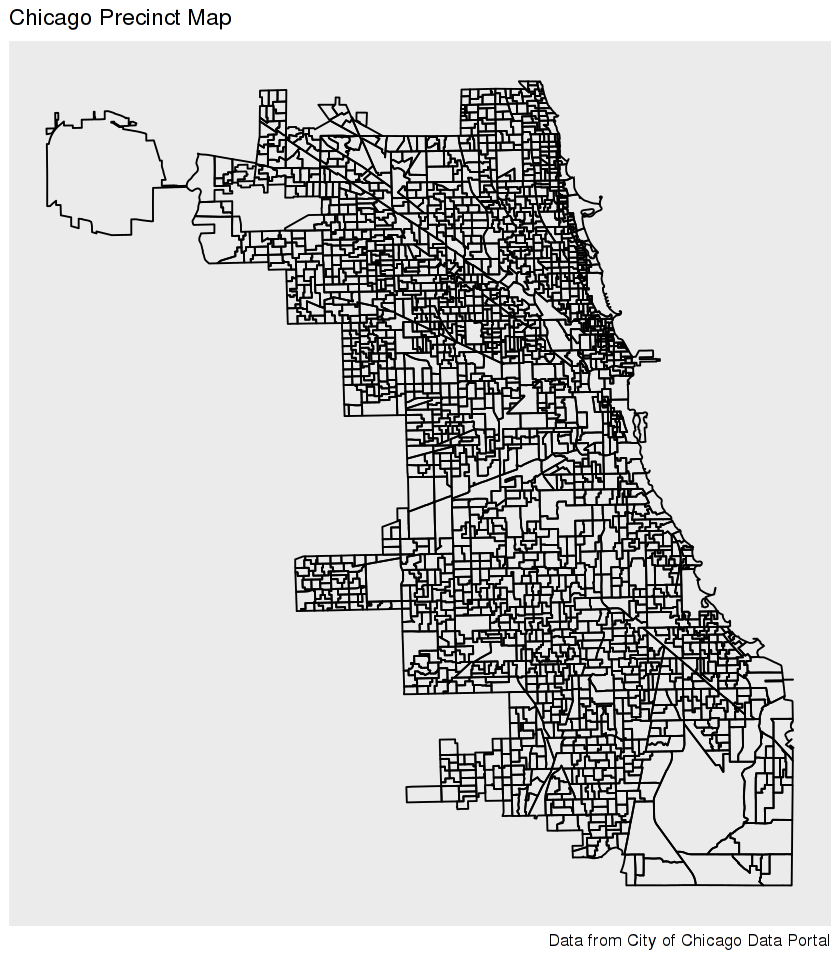

In [55]:
#---required!!
require(ggplot2)

#---resize plots, Chicago map has a lot of detail.
options(
    repr.plot.width=7, 
    repr.plot.height=8
)


#---create a chicago precinct map
precinct.map<-
    #---ggplot!!
    ggplot(
        #---precinct data
        data=precinct.boundaries,
        #---aesthetics...
        aes(
            #---long and lat
            x=long,
            y=lat,
            #---group by precinct
            group=precinct
        )
    
    )+

    #---geometry!  connect points with a path
    geom_path(
        #---color and size
        size=.3,
        color="black"
    )+

    #---no numbers on the axes
    scale_x_continuous(breaks=NULL)+
    scale_y_continuous(breaks=NULL)+
    
    #---labels
    labs(
        #---title
        title="Chicago Precinct Map",
        #---no axis titles
        x=NULL,
        y=NULL,
        #---caption
        caption="Data from City of Chicago Data Portal"
    )

#---plot the map!!!
precinct.map


Our fair city!!  I would guess many folks in Chicago would recognize that map without any labels.  But I'm sure many people, even in Chicago, would not.  So, the last thing I'll try to manage right now:  can I get a map image underneath that?

I know there's a way to do that using the `ggmap` package.  But, since I last used that (three or so years ago??) Google has required that you provide credit card information and register somehow with them.  That sounds like a not-awesome adventure, but one that I'll risk wading through.  Coming next...

